# Imports and Hyperparameters

In [1]:
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.onnx
import plotly.io as pio
import copy

%load_ext autoreload
%autoreload 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed = 30
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

pio.templates.default = "plotly_dark"

# DATA PARAMETERS
num_evaluation_samples = 50                                       
inf_repacement = 1000

# TRAINING PARAMETERS
training_set_proportion = 0.8                         
num_epochs = 500                                    
batch_size = 50          
learning_rate = 0.001
kl_weight = 0.0001

# MODEL PARAMETERS
latent_dims = 4

In [20]:
! pip3 install -r requirements.txt

  Using cached nbformat-4.2.0-py2.py3-none-any.whl.metadata (1.1 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached pyro_api-0.1.2-py3-none-any.whl.metadata (2.5 kB)
Using cached nbformat-4.2.0-py2.py3-none-any.whl (153 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 9.3 MB/s eta 0:00:00:00:010:01
Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
Using cached pyro_api-0.1.2-py3-none-any.whl (11 kB)
  Attempting uninstall: nbformat
    Found existing installation: nbformat 5.10.4
    Uninstalling nbformat-5.10.4:
      Successfully uninstalled nbformat-5.10.4


# Preprocessing

Requirements:
- one random constant
- one generate equation
- values of the instantiated equation

![](./images/dataloader.png)

In [2]:
%reload_ext autoreload
from src.preprocessing import generate_dataset, preprocessing
from src.evaluation import generate_values
import json
import equation_tree
from equation_tree.util.conversions import infix_to_prefix, prefix_to_infix
from src.preprocessing import EquationDatasetClassify
import random
from torch.utils.data import Dataset, DataLoader, TensorDataset
from equation_tree.tree import node_from_prefix

is_function = lambda x: x in ["sin", "exp"]
is_operator = lambda x : x in ["+", "-", "*"]
is_variable = lambda x : x in ["x_1", "x_1", "X"]
is_constant = lambda x : x in ["c_0"]
max_len = 0
# read json file 
classes = json.load(open('second_order_simple.json', 'r'))

# transfrom to prefix notation
classes_list = []
global classes_dict
classes_dict = {}
for cl in classes:
    try:
        eq_prefix = infix_to_prefix(cl.replace('X', 'x_1', ), is_function, is_operator)
        inf_eq = prefix_to_infix(eq_prefix, is_function, is_operator)
        classes_list.append(eq_prefix)
        classes_dict[cl] = eq_prefix
    except:
        pass

equations = []
values = []
constants = []

# generate dataset
for e, cl in enumerate(classes_list):
    for i in range(100):
        c = random.random()*10
        v = generate_values(cl, c, is_function, is_operator, is_variable, is_constant, infix=classes[e])
        if len(cl) > max_len:
             max_len = len(cl)
        if v != (None,):
            equations.append(cl)
            values.append(v)
            constants.append([c])

equations_final = []
for eq_prefix in equations:
    # try block due to complex infinity exception
    # add padding so that all equations have the same shape
    if len(eq_prefix) < max_len:
        eq_prefix = eq_prefix + ["<PAD>"] * (max_len - len(eq_prefix))
    # add equations, constants and values to their list
    equations_final.append(eq_prefix)


all_symbols = [item for sublist in equations_final for item in sublist]
unique_symbols = sorted(list(set(all_symbols)))

# obtain mapping from symbols to indices and vice versa
symb_to_idx = {symbol: idx for idx, symbol in enumerate(unique_symbols)}
idx_to_symb = {idx: symb for symb, idx in symb_to_idx.items()}

dataset = EquationDatasetClassify(equations_final, values, symb_to_idx,len(unique_symbols), constants)

classes = set(tuple(i) for i in equations_final)
classes = [list(i) for i in classes]
classes = [dataset.encode_equation(i) for i in classes]
print(len(classes), len(dataset))

train_loader, test_loader, test_size = preprocessing(
    dataset=dataset,
    batch_size=batch_size,
    training_set_proportion=training_set_proportion
)
max_len

37 3700


6

In [3]:
%reload_ext autoreload
from src.evaluation import plot_functions

# visualize 20 first equations in the dataset
plot_functions(
    equations=equations[:20],
    constants=constants[:20],
    values=values[:20],
    is_function=is_function,
    is_operator=is_operator,
)

# Autoencoder Training

In [4]:
from src.training import training_AE_C
autoencoder_equations, train_losses, test_losses, correlations_cor, correlations_dis, correlations_dis_train, x_batches, x_hat_batches, df_results = training_AE_C(train_loader, test_loader, latent_dims, unique_symbols, num_epochs, learning_rate, test_size, max_len, classes, 1.0)
best_correlation_dis = df_results['correlation_dis']
best_correlation_cor = df_results['correlation_cor']

Epoch 1/500, Training Loss: 5.006840229034424, Test Loss: 5.477006886456464, Correlation Cor: -0.024331752210855484, Correlation Dis: 0.12827107310295105
Epoch 2/500, Training Loss: 4.486145496368408, Test Loss: 4.563654545191172, Correlation Cor: -0.031042302027344704, Correlation Dis: 0.1420522779226303
Epoch 3/500, Training Loss: 4.403660774230957, Test Loss: 4.4650754735276506, Correlation Cor: -0.04470121115446091, Correlation Dis: 0.16528959572315216
Epoch 4/500, Training Loss: 3.998514175415039, Test Loss: 4.452827112094776, Correlation Cor: -0.029083717614412308, Correlation Dis: 0.17969322204589844
Epoch 5/500, Training Loss: 4.401150703430176, Test Loss: 4.435046724371008, Correlation Cor: -0.03881257399916649, Correlation Dis: 0.20316804945468903
Epoch 6/500, Training Loss: 4.458697319030762, Test Loss: 4.434598929173237, Correlation Cor: -0.03497331961989403, Correlation Dis: 0.21583496034145355
Epoch 7/500, Training Loss: 4.316367149353027, Test Loss: 4.344621535894033, Co

## VAE

In [5]:
from src.training import training_VAE_C
autoencoder_equations, train_losses, test_losses, correlations_cor, correlations_dis, x_batches, x_hat_batches, df_results = training_VAE_C(train_loader, test_loader, latent_dims, unique_symbols, num_epochs, learning_rate, test_size, kl_weight, classes, max_len, 1.0)

Epoch 1/500, Training Loss: 4.398160934448242, Test Loss: 4.825841291530712, Correlation_cor: -0.037180885672569275, Correlation_dis: 0.2044144570827484
Epoch 2/500, Training Loss: 4.2144455909729, Test Loss: 4.654482435535741, Correlation_cor: -0.04515915736556053, Correlation_dis: 0.21513670682907104
Epoch 3/500, Training Loss: 4.283492088317871, Test Loss: 4.475610623488555, Correlation_cor: -0.051979683339595795, Correlation_dis: 0.334553986787796
Epoch 4/500, Training Loss: 4.167717456817627, Test Loss: 4.410866879128121, Correlation_cor: -0.02502620220184326, Correlation_dis: 0.35311105847358704
Epoch 5/500, Training Loss: 3.8942031860351562, Test Loss: 4.25345838392103, Correlation_cor: -0.020811477676033974, Correlation_dis: 0.5327209830284119


KeyboardInterrupt: 

## Loss curves

/Users/lisa/Developer/CompNeuro_Autoencoder/src/utils.py:50: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



Last 10 epochs average correlation: -0.017813326418399812
Last 10 epochs average correlation: 0.9699908256530761


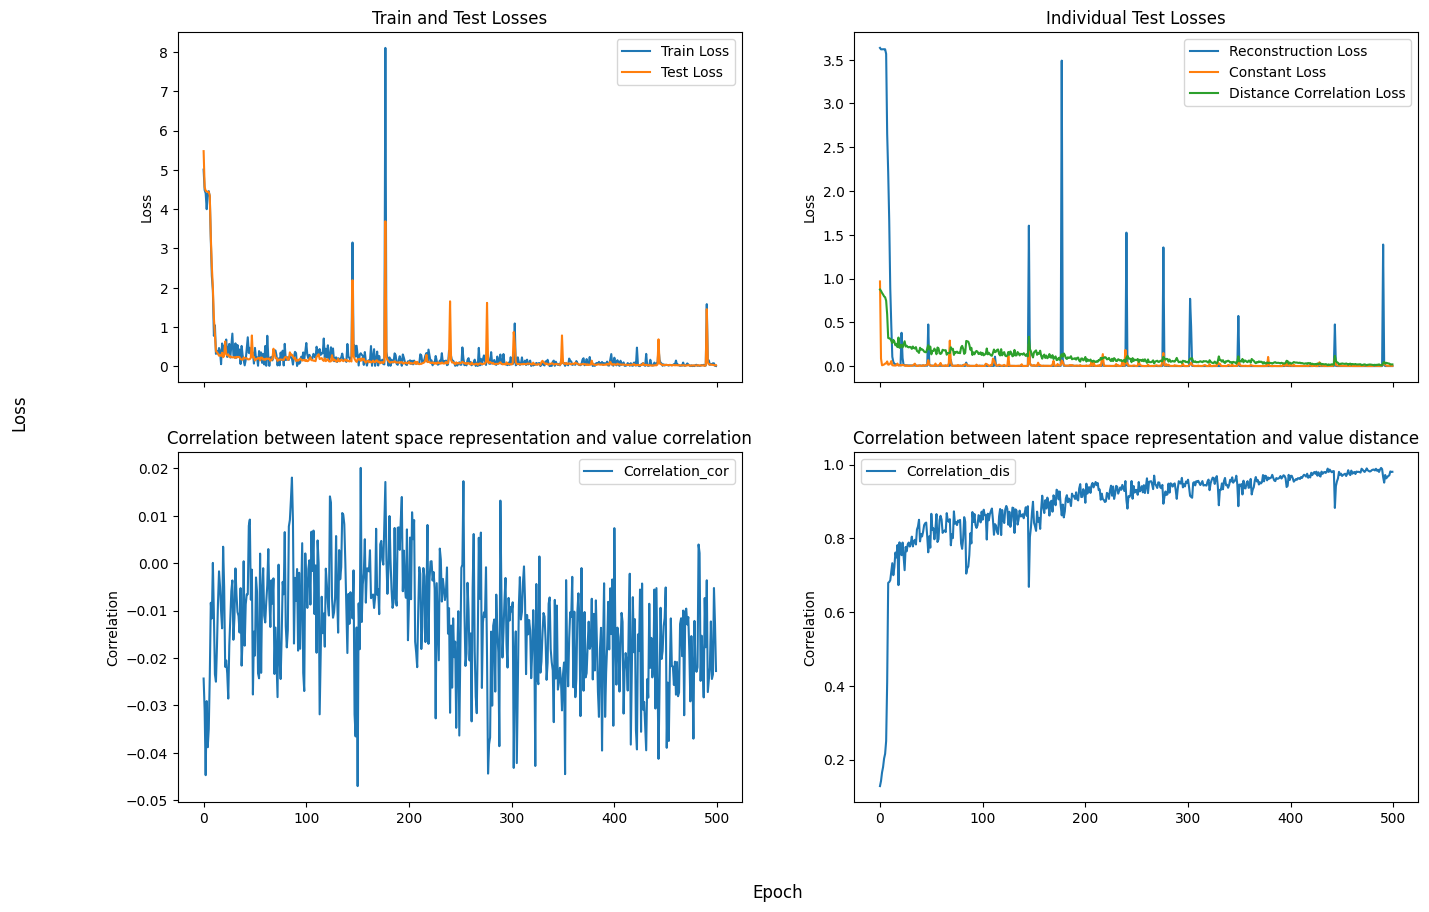

In [8]:
%reload_ext autoreload
from src.utils import plot_losses

plot_losses(
    train_losses,
    test_losses,
    correlation_cor=correlations_cor,
    correlation_dis=correlations_dis,
    df = df_results,
)
last_correlations_cor = np.sum(correlations_cor[-10:]) / 10
last_correlations_dis = np.sum(correlations_dis[-10:]) / 10
print(f"Last 10 epochs average correlation: {last_correlations_cor}")
print(f"Last 10 epochs average correlation: {last_correlations_dis}")

# Evaluation





In [9]:
%reload_ext autoreload
from src.evaluation import evaluation_ec
from src.evaluation import get_latent_representation
from equation_tree.util.conversions import prefix_to_infix
from src.evaluation import get_interpolated_df


x_hat_batches_n = [torch.argmax(batch[0], dim=1).tolist() for batch in x_hat_batches]
# constants

for i, batch in enumerate(x_hat_batches_n):
    for j, eq in enumerate(batch):
        x_hat_batches_n[i][j] = classes[eq]

# concatenate all batches
x_hat_batches_n = [item for sublist in x_hat_batches_n for item in sublist]
x_batches_n = [item for sublist in x_batches for item in sublist[0]]
x_constants = [item for sublist in x_batches for item in sublist[1]]
# caclulate accuracy
count = 0
for rec, real in zip(x_hat_batches_n, x_batches_n):
    if rec == real.tolist():
        count += 1
    else: 
        print(f"rec: {rec}, real: {real}")

accuracy = count / (len(x_hat_batches_n))
print(f"Equation reconstruction accuracy: {accuracy * 100}%")

Equation reconstruction accuracy: 100.0%




## Correlation


In [10]:
%reload_ext autoreload
import plotly.express as px


fig = px.imshow([[1, correlations_dis[-1] ], 
                 [correlations_dis[-1], 1]], 
                 x = ["Latent Space", "Function Correlation"], 
                 y = ["Latent Space", "Function Correlation"], 
                 color_continuous_scale='RdBu', 
                 title="Correlation Matrix")
fig.update_xaxes(side="top")
fig.show()
print(f"Correlation between Latent Space and Function correlation: {correlations_dis[-1]}")




Correlation between Latent Space and Function correlation: 0.980428159236908


## Visualizations

In [11]:

latent_space_representation, x_decoded, test_values, = get_latent_representation(
    model=autoencoder_equations,
    device=device,
    test_dataloader=test_loader,
    x_batches_p=x_batches_n,
    x_hat_batches_p=x_hat_batches_n,
    equation_tree_dataset=dataset,
    num_interpolations=5
)
len(latent_space_representation)

740

### Visualization of Latent Space
Plot the first 3 latent space dimensions

In [13]:
from plotly.offline import plot
import plotly.express as px
from equation_tree.util.conversions import prefix_to_infix

df = {
    "x": latent_space_representation[:, 0],
    "y": latent_space_representation[:, 1],
    "z": latent_space_representation[:, 2],
    "category": [prefix_to_infix(dataset.decode_equation(eq.tolist()), is_function, is_operator).replace("c_0", str(round(float(const[0]),2))) for eq, const in zip(x_decoded, x_constants)], #TODO: replace constant wit real value
}
df = pd.DataFrame(df)
fig = px.scatter_3d(
    df,
    x="x",
    y="y",
    z="z",
    color="category",
    title="Latent Space Representation",
    size_max=0.1,
)
plot(fig, filename="latent_space.html", auto_open=False, image="png")
fig.show()

<Axes: xlabel='x', ylabel='y'>

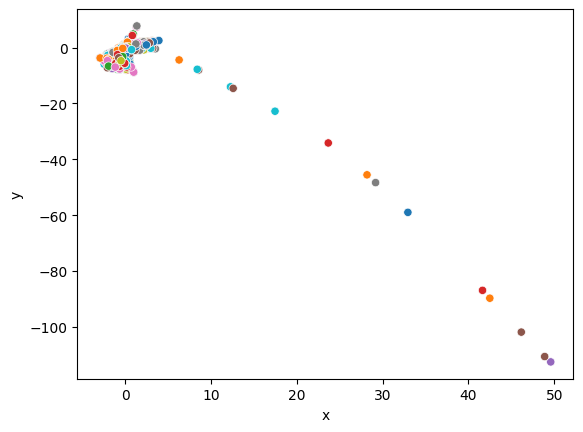

In [14]:
from colour import Color
import seaborn as sns
import matplotlib.pyplot as plt
# plots the first 2 dimensions of the latent space
sns.scatterplot(df, x="x", y="y",hue='category', legend=False, palette="tab10")

### Plot interpolations

In [16]:
from src.evaluation import plot_interpolations
equation_1 = 'x_1*c_1'
equation_2 = 'x_1+c_1'
df, _ = get_interpolated_df(
    kind="classifier",
    model=autoencoder_equations,
    equation_tree_dataset=dataset,
    latent_space_representation=latent_space_representation,
    equation_1=equation_1,
    equation_2=equation_2,
    c_1=-1.0,
    c_2=1.0,
    num_interpolations=20,
    assignment=(is_function, is_operator, is_variable, is_constant),
    classes=classes,
)
if len(df.values)> 0:
    fig = plot_interpolations(df, assignment=(is_function, is_operator, is_variable, is_constant))
    fig.show()

['*', 'x_1', 'c_1', '<PAD>', '<PAD>', '<PAD>']
reconstructed euqation 1: ['-', 'c_0', 'sin', 'x_1', '<PAD>', '<PAD>'], reconstructed equation 2: ['+', 'x_1', 'c_0', '<PAD>', '<PAD>', '<PAD>']
22 out of 22 equations were successfully evaluated


In [17]:
%autoreload
from src.evaluation import plot_interpolations, generate_values

# plot the interpolation between two functions
for i in range(1):
    rand_idx1 = random.randint(0, len(x_batches_n))
    rand_idx2 = random.randint(0, len(x_batches_n))
    df, _ = get_interpolated_df(
        kind="classifier",
        model=autoencoder_equations,
        equation_tree_dataset=dataset,
        latent_space_representation=latent_space_representation,
        equation_1=rand_idx1,
        equation_2=rand_idx2,
        c_1=1.5,
        c_2=0.5,
        num_interpolations=20,
        assignment=(is_function, is_operator, is_variable, is_constant),
        classes=classes,
    )
    if len(df.values)> 0:
        fig = plot_interpolations(df, assignment=(is_function, is_operator, is_variable, is_constant))
        fig.show()


reconstructed euqation 1: ['*', 'c_0', 'exp', 'x_1', '<PAD>', '<PAD>'], reconstructed equation 2: ['*', 'c_0', 'exp', 'x_1', '<PAD>', '<PAD>']
22 out of 22 equations were successfully evaluated


## Random Embedding

In [18]:
from src.evaluation import random_embedding

# evaluate how many of the random embeddings returned valid functions
random_embedding('AE_C', autoencoder_equations, dataset, latent_dims, (is_function, is_operator, is_variable, is_constant), classes=classes)

Managed to plot 100 out of 100


100

# Sytematic Evaluation
Every parameter change is evaluated 10 times.

## Analyse number of latent units

In [18]:
%reload_ext autoreload
from src.evaluation import evaluate_different_models

datasets = [dataset] * 10

kind = "VAE_C"
weight = 1.0
kl_weight = 0.0001

df_units = pd.DataFrame(columns=['latent dims', 'correlation_cor', 'correlation_dis', 'correlation_cor last 10 epochs', 'correlation_dis last 10 epochs', 'recovered equations', 'accuracy (individualt)', 'accuracy equations', 'constant MSE', 'average distance constants'])
count = 0
for d in datasets: 
    count += 1
    for units in [32, 64, 128]: 
        print(f"Dataset {count} with {units} units")
        dct = evaluate_different_models(d, batch_size, training_set_proportion, units, num_epochs, learning_rate, kind, weight, classes=classes, assignments=(is_function, is_operator, is_variable, is_constant), klweight=kl_weight)
        print(f"Correlation: {dct['correlation_dis']}, Accuracy: {dct['accuracy equations']}")
        df = pd.DataFrame(dct, index=[0])
        df_units = pd.concat([df_units, df], ignore_index=True, axis=0)
df_units.to_csv('results/latent_dims_vae_calssify_big_final.csv', index=False)

Dataset 1 with 32 units
Correlation: 0.9372802972793579, Accuracy: 1.0
Dataset 1 with 64 units
Correlation: 0.9032774567604065, Accuracy: 1.0
Dataset 1 with 128 units
Correlation: 0.90440833568573, Accuracy: 0.9986486486486487
Dataset 2 with 32 units
Correlation: 0.9421399235725403, Accuracy: 1.0
Dataset 2 with 64 units
Correlation: 0.9226039052009583, Accuracy: 0.9986486486486487
Dataset 2 with 128 units
Correlation: 0.8732423782348633, Accuracy: 0.9986486486486487
Dataset 3 with 32 units
Correlation: 0.9368297457695007, Accuracy: 0.9986486486486487
Dataset 3 with 64 units
Correlation: 0.9007872343063354, Accuracy: 0.9986486486486487
Dataset 3 with 128 units
Correlation: 0.901046097278595, Accuracy: 0.9986486486486487
Dataset 4 with 32 units
Correlation: 0.9397627115249634, Accuracy: 1.0
Dataset 4 with 64 units
Correlation: 0.9196115136146545, Accuracy: 0.9986486486486487
Dataset 4 with 128 units
Correlation: 0.9041623473167419, Accuracy: 0.995945945945946
Dataset 5 with 32 units
Corr

## Analyse KL weighting

In [61]:
from src.evaluation import evaluate_different_models
datasets = [dataset] * 10
kind = "VAE_C"

#df_weight = pd.DataFrame(columns=['latent dims', 'correlation_cor', 'correlation_dis', 'correlation_cor last 10 epochs', 'correlation_dis last 10 epochs', 'recovered equations', 'accuracy (individual)', 'accuracy equations', 'constant MSE', 'average distance constants', 'weight', 'kl_weight', 'test_reconstruction_loss', 'test_constant_loss', 'test_latent_correlation_loss', 'test_kl_divergence', 'correlations_dis_train'])


count = 0
for d in datasets: 
    count += 1
    for klweight in [0.00001]: 
        print(f"Dataset {count} with a weighting of {klweight} for the latent correlation loss")
        dct = evaluate_different_models(d, batch_size, training_set_proportion, latent_dims, num_epochs, learning_rate, kind, 1.0, klweight=klweight, classes=classes, assignments=(is_function, is_operator, is_variable, is_constant))
        #print(dct)
        print(f"Correlation: {dct['correlation_dis']}, Accuracy: {dct['accuracy equations']}")
        df = pd.DataFrame(dct, index=[0])
        df_weight = pd.concat([df_weight, df], ignore_index=True, axis=0)
df_weight.to_csv('results/classify_klweight_2.csv', index=False)

Dataset 1 with a weighting of 1e-05 for the latent correlation loss
Correlation: 0.9416525959968567, Accuracy: 0.9986486486486487
Dataset 2 with a weighting of 1e-05 for the latent correlation loss
Correlation: 0.9571542143821716, Accuracy: 1.0
Dataset 3 with a weighting of 1e-05 for the latent correlation loss
Correlation: 0.9478994607925415, Accuracy: 1.0
Dataset 4 with a weighting of 1e-05 for the latent correlation loss
Correlation: 0.8840537667274475, Accuracy: 1.0
Dataset 5 with a weighting of 1e-05 for the latent correlation loss
Correlation: 0.9433335661888123, Accuracy: 0.9986486486486487
Dataset 6 with a weighting of 1e-05 for the latent correlation loss
Correlation: 0.8001194000244141, Accuracy: 1.0
Dataset 7 with a weighting of 1e-05 for the latent correlation loss
Correlation: 0.9686968326568604, Accuracy: 1.0
Dataset 8 with a weighting of 1e-05 for the latent correlation loss
Correlation: 0.8945666551589966, Accuracy: 1.0
Dataset 9 with a weighting of 1e-05 for the latent

## Learning Rate Analysis

In [73]:
from src.evaluation import evaluate_different_models
datasets = [dataset] * 10
is_VAE = True
if is_VAE:
    df_lr = pd.DataFrame(columns=['latent dims', 'correlation_cor', 'correlation_dis', 'correlation_cor last 10 epochs', 'correlation_dis last 10 epochs', 'recovered equations', 'accuracy (individualt)', 'accuracy equations', 'constant MSE', 'average distance constants', 'kl_weight', 'test_reconstruction_loss', 'test_constant_loss', 'test_latent_correlation_loss', 'test_kl_divergence', 'correlation_dis reonstructed equations', 'learning_rate'])
else:
    df_lr = pd.DataFrame(columns=['latent dims', 'correlation_cor', 'correlation_dis', 'correlation_cor last 10 epochs', 'correlation_dis last 10 epochs', 'recovered equations', 'accuracy (individualt)', 'accuracy equations', 'constant MSE', 'average distance constants', 'learning_rate'])

kind = 'VAE_C'
count = 0
for d in datasets: 
    count += 1
    for lr in [0.00001, 0.0001, 0.001, 0.01, 0.1]: 
        print(f"Dataset {count} with {lr} learning rate")
        dct = evaluate_different_models(d, batch_size, training_set_proportion, latent_dims, num_epochs, lr, kind, 1.0, klweight=klweight, classes=classes, assignments=(is_function, is_operator, is_variable, is_constant))
        df = pd.DataFrame(dct, index=[0])
        print(f"Correlation: {dct['correlation_dis']}, Accuracy: {dct['accuracy equations']}")
        df_lr = pd.concat([df_lr, df], ignore_index=True, axis=0)
df_lr.to_csv('results/learning_rate_vae_classify.csv', index=False)

Dataset 1 with 1e-05 learning rate
Correlation: 0.7805308699607849, Accuracy: 0.2905405405405405
Dataset 1 with 0.0001 learning rate
Correlation: 0.853289783000946, Accuracy: 0.9986486486486487
Dataset 1 with 0.001 learning rate
Correlation: 0.9867587685585022, Accuracy: 1.0
Dataset 1 with 0.01 learning rate
Correlation: 0.9130426049232483, Accuracy: 0.9986486486486487
Dataset 1 with 0.1 learning rate
Correlation: nan, Accuracy: 0.02837837837837838
Dataset 2 with 1e-05 learning rate
Correlation: 0.826092004776001, Accuracy: 0.08378378378378379
Dataset 2 with 0.0001 learning rate
Correlation: 0.7984609007835388, Accuracy: 1.0
Dataset 2 with 0.001 learning rate
Correlation: 0.9891386032104492, Accuracy: 1.0
Dataset 2 with 0.01 learning rate
Correlation: 0.9254373908042908, Accuracy: 1.0
Dataset 2 with 0.1 learning rate
Correlation: nan, Accuracy: 0.022972972972972974
Dataset 3 with 1e-05 learning rate
Correlation: 0.6132324934005737, Accuracy: 0.08243243243243244
Dataset 3 with 0.0001 le

## Latent Correlation weighting

In [6]:
from src.evaluation import evaluate_different_models
datasets = [dataset] * 10
kind = "VAE_C"

df_weight = pd.DataFrame(columns=['latent dims', 'correlation_cor', 'correlation_dis', 'correlation_cor last 10 epochs', 'correlation_dis last 10 epochs', 'recovered equations', 'accuracy (individual)', 'accuracy equations', 'constant MSE', 'average distance constants', 'weight', 'kl_weight', 'test_reconstruction_loss', 'test_constant_loss', 'test_latent_correlation_loss', 'test_kl_divergence', 'correlations_dis_train'])


count = 0
for d in datasets: 
    count += 1
    for weight in [0, 0.1, 1, 10, 100, 1000]: 
        print(f"Dataset {count} with a weighting of {weight} for the latent correlation loss")
        dct = evaluate_different_models(d, batch_size, training_set_proportion, latent_dims, num_epochs, learning_rate, kind, weight, klweight=kl_weight, classes=classes, assignments=(is_function, is_operator, is_variable, is_constant))
        #print(dct)
        print(f"Correlation: {dct['correlation_dis']}, Accuracy: {dct['accuracy equations']}")
        df = pd.DataFrame(dct, index=[0])
        df_weight = pd.concat([df_weight, df], ignore_index=True, axis=0)
df_weight.to_csv('results/classify_weight_vae.csv', index=False)

Dataset 1 with a weighting of 0 for the latent correlation loss
Correlation: 0.03412412479519844, Accuracy: 1.0
Dataset 1 with a weighting of 0.1 for the latent correlation loss
Correlation: 0.6785495281219482, Accuracy: 1.0
Dataset 1 with a weighting of 1 for the latent correlation loss
Correlation: 0.9774346947669983, Accuracy: 1.0
Dataset 1 with a weighting of 10 for the latent correlation loss
Correlation: 0.9955599308013916, Accuracy: 1.0
Dataset 1 with a weighting of 100 for the latent correlation loss
Correlation: 0.9989069104194641, Accuracy: 1.0
Dataset 1 with a weighting of 1000 for the latent correlation loss
Correlation: 0.9997549057006836, Accuracy: 0.9986486486486487
Dataset 2 with a weighting of 0 for the latent correlation loss
Correlation: 0.22712470591068268, Accuracy: 1.0
Dataset 2 with a weighting of 0.1 for the latent correlation loss
Correlation: 0.7634422183036804, Accuracy: 1.0
Dataset 2 with a weighting of 1 for the latent correlation loss
Correlation: 0.970276

# Sampling

In [21]:
import pyro
import pyro.distributions as dist
from src.evaluation import generate_values, decode_latent_classify
#target_function = "(c_0-x_1)*exp(x_1)"
target_function = "exp(x_1)*c_0"
#target_function = "x_1+exp(x_1)+c_0"
target_function = "c_0*x_1"
num_samples = 1000
target_constant = 5.0
target_dist = generate_values(target_function, target_constant, is_function, is_operator, is_variable, is_constant)
iteration_values = []

# define the probabilistic model
def probabilistic_model(data):
    latent_variables = []
    for i in range(latent_dims):
        latent_variables.append(pyro.sample(f"latent_variable_{i}", dist.Normal(0, 5)))
    variance = torch.tensor(0.1) * 50

    embedding = [latent_variables]

    equations, constants = decode_latent_classify(autoencoder_equations, dataset, embedding, classes)
    values = generate_values(equations[0], constants[0][0][0], is_function, is_operator, is_variable, is_constant)[1]
    try: 
        values = torch.tensor(values, dtype=torch.float32)
    except:
        print(values)
        print(type(values))
    
    pyro.sample(f"observed_data", dist.Normal(values, variance).to_event(1), obs=data)

[autoreload of nbformat.v1.rwbase failed: Traceback (most recent call last):
  File "/Users/lisa/Developer/CompNeuro_Autoencoder/comp_neuro/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/lisa/Developer/CompNeuro_Autoencoder/comp_neuro/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/Users/lisa/Developer/CompNeuro_Autoencoder/comp_neuro/lib/python3.9/site-packages/nbformat/v1/rwbase.py", line 19, in <module>
    from bas

## run MCMC

In [22]:

import pyro.infer
import pyro.optim
import pyro.poutine as poutine
import torch
from pyro.infer import MCMC, NUTS
pyro.clear_param_store()


observed_data = torch.tensor(target_dist[1])

nuts_kernel = NUTS(probabilistic_model)

mcmc = MCMC(nuts_kernel, num_samples=num_samples, warmup_steps=200)

mcmc.run(torch.tensor(target_dist[1]))

samples = mcmc.get_samples()
print(samples)



Warmup:   2%|▏         | 24/1200 [01:05,  3.27s/it, step size=1.84e-04, acc. prob=0.632]

In [90]:
results = []
# take just the mean of the samples
for i in range(latent_dims):
    results.append(samples[f'latent_variable_{i}'].mean())

# sample from the distribution
results_sampled = []
#for i in range(latent_dims):
    #results_sampled.append(dist.Normal(samples[f'latent_variable_{i}'].mean(), samples[f'latent_variable_{i}'].std()).sample())

# random embedding
random_samples = []
for i in range(latent_dims):
    random_samples.append(dist.Normal(0, 5).sample())

# decode results
results_dec = decode_latent_classify(autoencoder_equations, dataset, [results], classes)
result_equation = results_dec[0][0]
result_constant = results_dec[1][0][0][0]

# decode random samples
random_dec = decode_latent_classify(autoencoder_equations, dataset, [random_samples], classes)
random_equation = random_dec[0][0]
random_constant = random_dec[1][0][0][0]

print(f"resulting function: {prefix_to_infix(result_equation, is_function, is_operator)} with constant {result_constant}")
print(observed_data)

v_sample = generate_values(result_equation, result_constant, is_function, is_operator, is_variable, is_constant)
v_real = generate_values(target_function, target_constant, is_function, is_operator, is_variable, is_constant)
v_random = generate_values(random_equation, random_constant, is_function, is_operator, is_variable, is_constant)

resulting function: ((c_0*x_1)-sin(x_1)) with constant 6.130268573760986
tensor([-5.0000, -4.7959, -4.5918, -4.3878, -4.1837, -3.9796, -3.7755, -3.5714,
        -3.3673, -3.1633, -2.9592, -2.7551, -2.5510, -2.3469, -2.1429, -1.9388,
        -1.7347, -1.5306, -1.3265, -1.1224, -0.9184, -0.7143, -0.5102, -0.3061,
        -0.1020,  0.1020,  0.3061,  0.5102,  0.7143,  0.9184,  1.1224,  1.3265,
         1.5306,  1.7347,  1.9388,  2.1429,  2.3469,  2.5510,  2.7551,  2.9592,
         3.1633,  3.3673,  3.5714,  3.7755,  3.9796,  4.1837,  4.3878,  4.5918,
         4.7959,  5.0000])


In [95]:
import seaborn as sns
import matplotlib.pyplot as plt
def plot_sampling_functions(smpls, with_Random):
    # latent variabls values
    latent_variable_MCMC = []
    equations_MCMC = []
    constants_MCMC = []
    # generate a list of lists for the latent variables of each iteration (num_iterations, latent_dims)
    for s in range(len(smpls['latent_variable_0'])):
        embedding = []
        for i in range(latent_dims):
            embedding.append(smpls[f'latent_variable_{i}'][s].item())
        equations, constants = decode_latent_classify(autoencoder_equations, dataset, [embedding], classes)
        values = torch.tensor(generate_values(equations[0], constants[0][0][0], is_function, is_operator, is_variable, is_constant)[1], dtype=torch.float32)
        latent_variable_MCMC += values.detach().numpy().tolist()
        constants_MCMC += [constants[0][0][0]]
        equations_MCMC += [prefix_to_infix(equations[0], is_function, is_operator)]*50

    df = {
        "y": latent_variable_MCMC,
        "x": np.linspace(-1,1,50).tolist() * num_samples,
        "equation": equations_MCMC

    }

    df_compare = {
        'x': np.linspace(-1, 1, 50),
        'y_sample': v_sample[1],
        'y_real': v_real[1],
        'y_random': v_random[1]
    }   
    print(f"the smallest constant is {min(constants_MCMC)} and the largest constant is {max(constants_MCMC)}")
    data = pd.DataFrame(df)
    #g = sns.lineplot(data=data, x='x', y='y', hue='equation', fit_reg=True, legend=False, height=5, scatter_kws={'alpha':0.5, 's': 0.05})
    sns.lineplot(data=data, x='x', y='y', hue='equation')
    #sns.lineplot(data=df_compare, x='x', y='y_sample', label=f"Sampled: {prefix_to_infix(result_equation, is_function, is_operator).replace('c_0', str(round(result_constant, 2)) )}")
    sns.lineplot(data=df_compare, x='x', y='y_real', label=f"Real: {target_function.replace('c_0', str(target_constant))}")
    if with_Random:
        sns.lineplot(data=df_compare, x='x', y='y_random', label=f"Random: {prefix_to_infix(random_equation, is_function, is_operator).replace('c_0', str(round(random_constant, 2)) )}")

    plt.legend(markerscale=30)




def plot_dist(smpls):
    # Plot resulting probability distribution
    fig, ax = plt.subplots()

    for i in range(latent_dims):
        sns.histplot(smpls[f'latent_variable_{i}'], kde=True, ax=ax)

    # add legend
    ax.legend([f"latent_variable_{i}" for i in range(latent_dims)])

    ax.set_title("Posterior distribution of the latent variables")
    plt.show()


the smallest constant is 1.9434101581573486 and the largest constant is 9.062533378601074


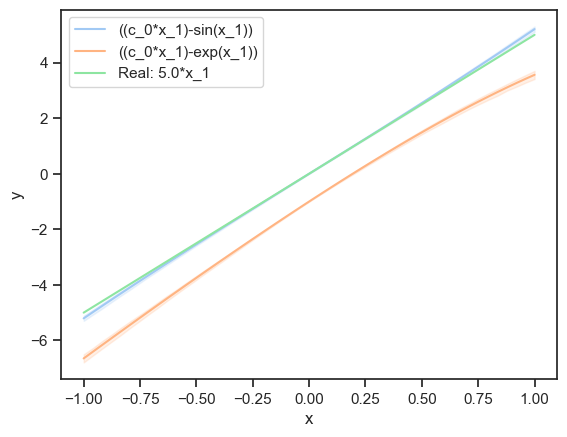

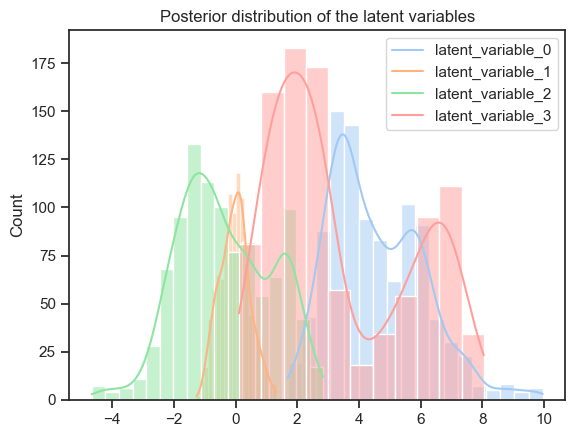

In [96]:
plot_sampling_functions(samples, False)
plot_dist(samples)

- MCMC_vae_1: baseline configuration
- MCMC_vae_2: only latentCorrelationLoss and kl_loss 
- MCMC_vae_3: 10*latentcorrelationloss (latent space more spreadout than before)
- MCMC_vae_4: baseline configuration 
- MCMC_vae_5: baseline configuration
- MCMC_vae_6: 8 latent dims
- MCMC_vae_7: 8 latent dims
- MCMC_vae_8 : same Model as 7 (MCMC run another time)
change likelihood function
- MCMC_vae_9: 8 latent dims
- MCMC_vae_10: 8 latent dims

## run Variational Inference

In [74]:
import pyro
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.infer.autoguide import AutoNormal, AutoMultivariateNormal
from pyro.infer import Predictive


pyro.clear_param_store()

def guide():
    latent_variables = []
    for i in range(latent_dims):
        latent_variables.append(pyro.param(f"latent_variable_{i}", torch.tensor(0.0)))
    latent_variables = torch.tensor(latent_variables, dtype=torch.float32)
    #with pyro.plate("data", len(latent_variables)):
    pyro.sample("latent_variables", dist.Normal(latent_variables, 5.0))

adam_params = {"lr": 0.005}
optimizer = Adam(adam_params)

auto_guide = AutoNormal(probabilistic_model)
guide_VI = guide()
svi = SVI(probabilistic_model, auto_guide, optimizer, loss=Trace_ELBO())

n_steps = 500001

observed_data = torch.tensor(target_dist[1])
losses = []

# training loop
for step in range(n_steps):
    loss = svi.step(observed_data)
    losses.append(loss)
    if step % 1000 == 0:
        print(f"step: {step}, loss: {loss}")

predictive_svi = Predictive(probabilistic_model, guide=auto_guide, num_samples=1000)(torch.tensor(target_dist[1]))
for k, v in predictive_svi.items():
    print(f"{k}: {tuple(v.shape)}")


step: 0, loss: 177.01521134376526
step: 1000, loss: 135.86148703098297
step: 2000, loss: 156.41990661621094
step: 3000, loss: 206.74605989456177
step: 4000, loss: 456.33873176574707
step: 5000, loss: 922.6458055973053
step: 6000, loss: 519.5509338378906
step: 7000, loss: 144.00582456588745
step: 8000, loss: 197.93354678153992
step: 9000, loss: 302.44670391082764
step: 10000, loss: 170.97104597091675
step: 11000, loss: 136.2344949245453
step: 12000, loss: 590.2981390953064
step: 13000, loss: 134.06320905685425
step: 14000, loss: 132.48657751083374
step: 15000, loss: 566.8286643028259
step: 16000, loss: 271.3050465583801
step: 17000, loss: 634.9104838371277
step: 18000, loss: 171.10113191604614
step: 19000, loss: 328.4133880138397
step: 20000, loss: 146.02036690711975
step: 21000, loss: 596.9854838848114
step: 22000, loss: 600.2636156082153
step: 23000, loss: 227.4461042881012
step: 24000, loss: 850.1818389892578
step: 25000, loss: 162.483149766922
step: 26000, loss: 227.47169661521912
s

KeyboardInterrupt: 

In [72]:
results_VI = []
# take just the mean of the samples
for i in range(latent_dims):
    results_VI.append(predictive_svi[f'latent_variable_{i}'].mean())

# sample from the distribution
results_sampled = []
#for i in range(latent_dims):
    #results_sampled.append(dist.Normal(samples[f'latent_variable_{i}'].mean(), samples[f'latent_variable_{i}'].std()).sample())

# random embedding
random_samples = []
for i in range(latent_dims):
    random_samples.append(dist.Normal(0, 5).sample())

# decode results
results_dec = decode_latent_classify(autoencoder_equations, dataset, [results_VI], classes)
result_equation = results_dec[0][0]
result_constant = results_dec[1][0][0][0]

# decode random samples
random_dec = decode_latent_classify(autoencoder_equations, dataset, [random_samples], classes)
random_equation = random_dec[0][0]
random_constant = random_dec[1][0][0][0]

print(f"resulting function: {prefix_to_infix(result_equation, is_function, is_operator)} with constant {result_constant}")
#print(observed_data)

v_sample = generate_values(result_equation, result_constant, is_function, is_operator, is_variable, is_constant)
v_real = generate_values(target_function, target_constant, is_function, is_operator, is_variable, is_constant)
v_random = generate_values(random_equation, random_constant, is_function, is_operator, is_variable, is_constant)

resulting function: (c_0-x_1) with constant 4.055308818817139


the smallest constant is -36.47755432128906 and the largest constant is 42.73858642578125


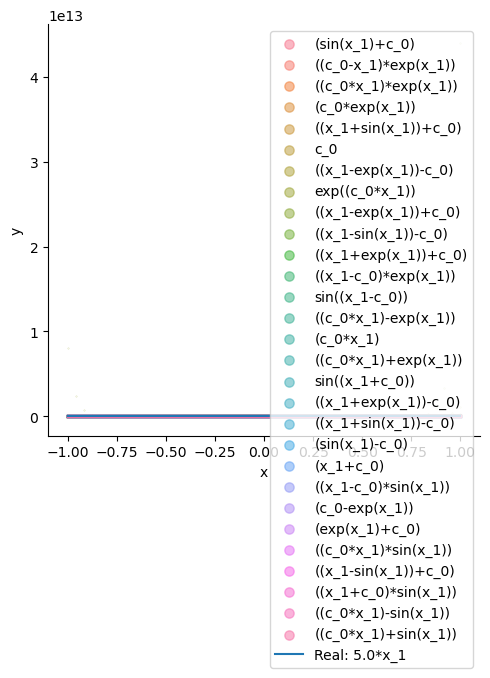

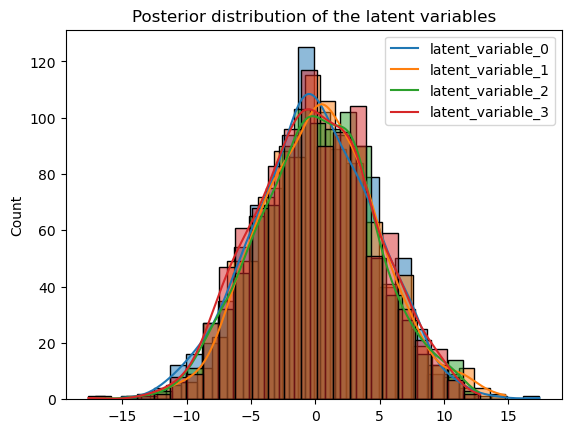

In [73]:
plot_sampling_functions(predictive_svi, False)
plot_dist(predictive_svi)

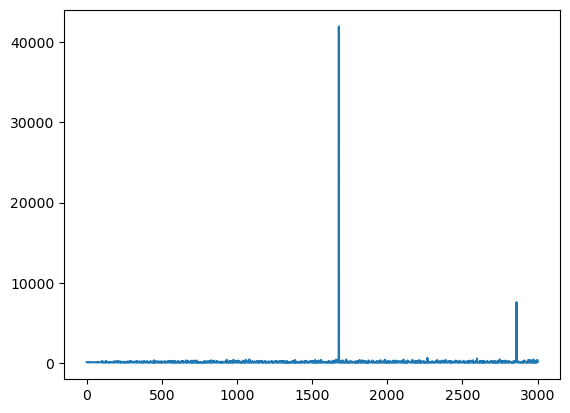

In [33]:
plt.plot (losses)